In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.artist import Artist

In [58]:
labels = ["name", "# ACM", "# TVGC", "# IEEE", "# paper reviews", "# mail/day", "co-reviewers" ]
A = ["A", 80, 20, 100, 500, 300, ["B","C","D"]]
B = ["B", 20,0,10,20,15, ["A","D"]]
C = ["C", 60,5,20,200,150,["A","B"]]
D = ["D", 50,8,100,300,120,["A","B","C"]]

df = pd.DataFrame([A,B,C,D], columns=labels)

In [59]:
print(df.head())

  name  # ACM  # TVGC  # IEEE  # paper reviews  # mail/day co-reviewers
0    A     80      20     100              500         300    [B, C, D]
1    B     20       0      10               20          15       [A, D]
2    C     60       5      20              200         150       [A, B]
3    D     50       8     100              300         120    [A, B, C]


In [60]:
# principal component analysis

numeric_data = df.select_dtypes(include=['int', 'float'])
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)
pca = PCA(n_components=3)
principal_components = pca.fit_transform(scaled_data)

principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])

final_df = pd.concat([principal_df, df[['name', 'co-reviewers']]], axis=1)

Not kept since it is hard to see the reality behind the principal components

In [63]:
# Feature selection
X = df.drop(["name", "co-reviewers"], axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["name"])
print(X.head())
print (y)
selector = SelectKBest(f_regression, k=3)
X_new = selector.fit_transform(X, y)
names_new = X.columns[selector.get_support(indices=True)]
new_df = pd.DataFrame(X_new, columns=names_new)
print(new_df.head())


   # ACM  # TVGC  # IEEE  # paper reviews  # mail/day
0     80      20     100              500         300
1     20       0      10               20          15
2     60       5      20              200         150
3     50       8     100              300         120
[0 1 2 3]
   # TVGC  # paper reviews  # mail/day
0      20              500         300
1       0               20          15
2       5              200         150
3       8              300         120


We omit the #ACM and #IEEE since they are highly correlated with the #TVGC.

In [15]:
print(df.head())
print(final_df.head())

  name  # ACM  # TVGC  # IEEE  # paper reviews  # mail/day co-reviewers
0    A     80      20     100              500         300    [B, C, D]
1    B     20       0      10               20          15       [A, D]
2    C     60       5      20              200         150       [A, B]
3    D     50       8     100              300         120    [A, B, C]
        PC1       PC2       PC3 name co-reviewers
0  3.054731 -0.172823  0.252227    A    [B, C, D]
1 -2.854389  0.096788  0.294826    B       [A, D]
2 -0.529255 -0.907966 -0.292477    C       [A, B]
3  0.328913  0.984001 -0.254577    D    [A, B, C]


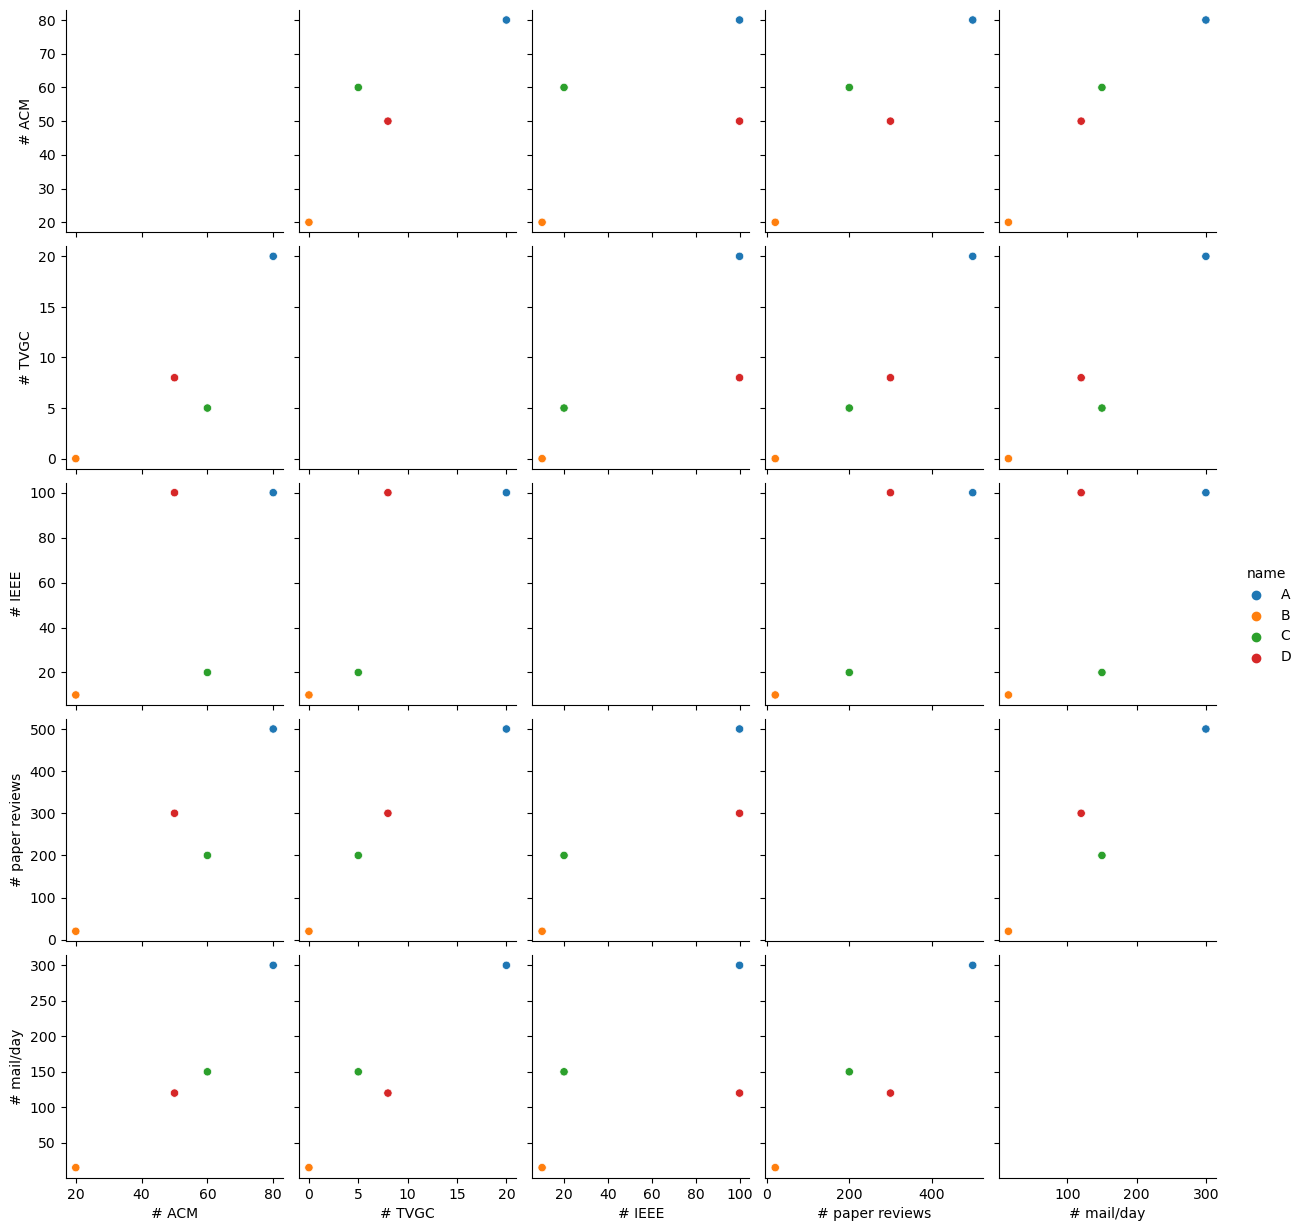

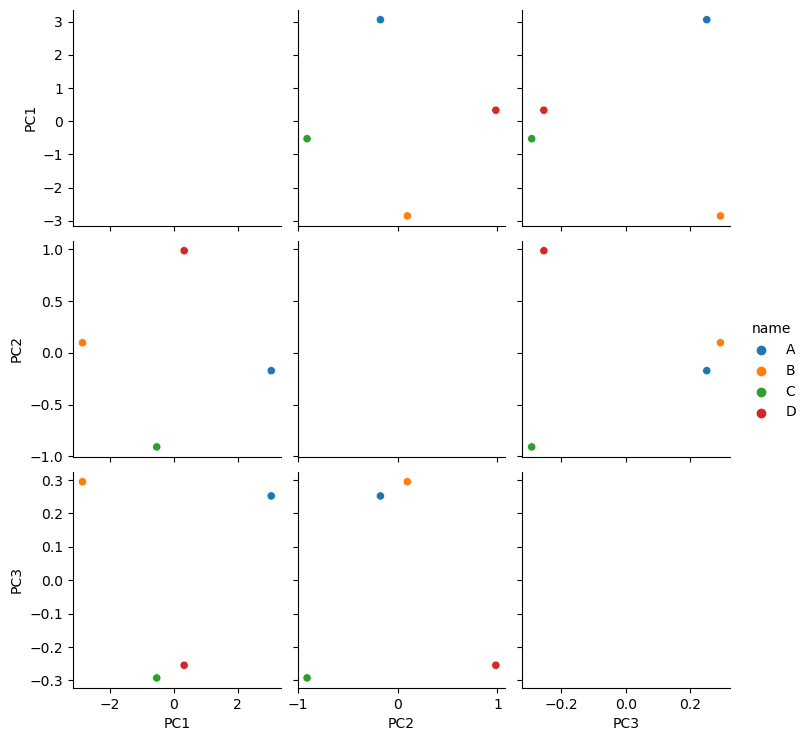

In [16]:
sns.pairplot(df, hue='name', height=2.5)
plt.show()
sns.pairplot(final_df, hue='name', height=2.5)
plt.show()

In [70]:
# we make a connection matrix for the co-reviewers
# the line is a persion, the column is a co-reviewer

name_to_index = {"A": 0, "B": 1, "C": 2, "D": 3}
N = len(name_to_index)
connection_matrix = np.zeros((N, N))
for ind in df.index:
    name_index = name_to_index[df['name'][ind]]
    connected_indices = [name_to_index[name] for name in df['co-reviewers'][ind]]
    connection_matrix[name_index, connected_indices] = 1

print(connection_matrix)

[[0. 1. 1. 1.]
 [1. 0. 0. 1.]
 [1. 1. 0. 0.]
 [1. 1. 1. 0.]]


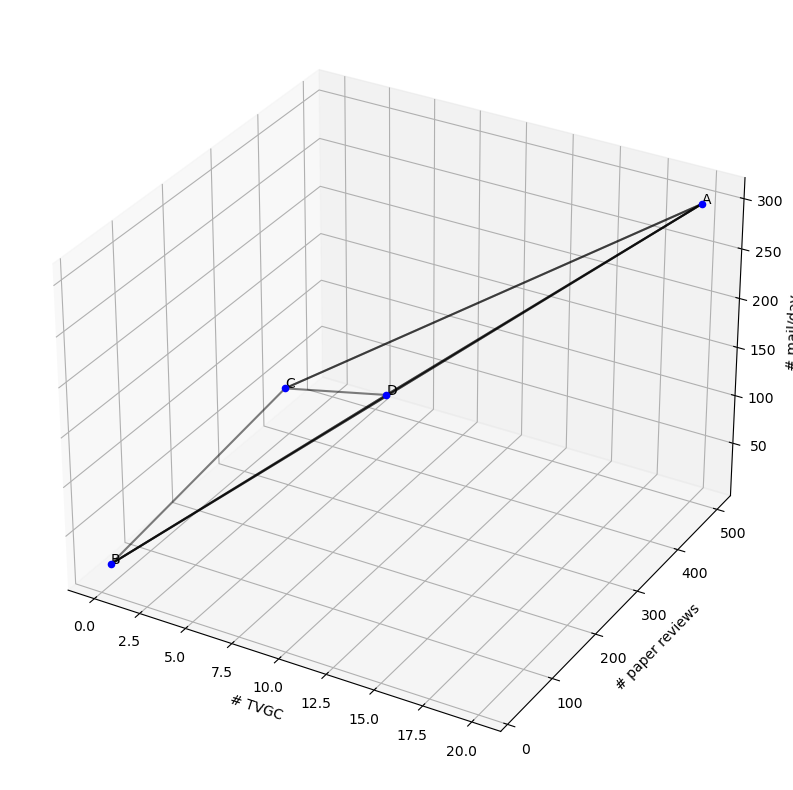

In [89]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

matrix = new_df.values
for i in range(np.shape(matrix)[0]):
    ax.scatter(matrix[i,0], matrix[i,1], matrix[i,2], c='b', picker=True, pickradius=5)

#connections
def create_connections(selectedPoint = -1):
    for i in range(len(connection_matrix)):
        for j in range(len(connection_matrix[i])):
            if connection_matrix[i,j] == 1:
                if selectedPoint == i:
                    ax.plot([matrix[i,0], matrix[j,0]], [matrix[i,1], matrix[j,1]], [matrix[i,2], matrix[j,2]], c='r', alpha=1, linewidth=3)
                else:
                    ax.plot([matrix[i,0], matrix[j,0]], [matrix[i,1], matrix[j,1]], [matrix[i,2], matrix[j,2]], c='k', alpha=0.5)
create_connections()
#labels
for i in range(len(matrix)):
    ax.text(matrix[i,0], matrix[i,1], matrix[i,2], df['name'][i], size=10, zorder=1, color='k')

#axes names
ax.set_xlabel(new_df.columns[0])
ax.set_ylabel(new_df.columns[1])
ax.set_zlabel(new_df.columns[2])


selectedPoint = None

# on clicking, we change the color of the point, and we print more information about the person
# and we draw the connections
def on_hover(event):
    global selectedPoint
    if selectedPoint != None:
        props = {'color': 'b'}
        Artist.update(selectedPoint, props)
    props = {'color': 'r'}
    Artist.update(event.artist, props)
    selectedPoint = event.artist

    selected_index = ax.collections.index(selectedPoint)
    print(selected_index)

    for i,txt in enumerate(ax.texts):
        features = df.loc[i, df.columns]
        if i == selected_index:
            string = ""
            for i,feature in enumerate(features):
                string += df.columns[i] + " : " + str(feature) + "\n"
            txt.set_text(string)
        else:
            txt.set_text(features['name'])
    print(selectedPoint)
    print(ax.texts)
    for plot in ax.lines:
        plot.remove()
    create_connections(selected_index)
    plt.draw()

    

fig.canvas.mpl_connect('pick_event', on_hover)
plt.show()